# The MS COCO classification challenge

Razmig Kéchichian

This notebook defines the multi-class classification challenge on the [MS COCO dataset](https://cocodataset.org/). It defines the problem, sets the rules of organization and presents tools you are provided with to accomplish the challenge.


## 1. Problem statement

Each image has **several** categories of objects to predict, hence the difference compared to the classification problem we have seen on the CIFAR10 dataset where each image belonged to a **single** category, therefore the network loss function and prediction mechanism (only highest output probability) were defined taking this constraint into account.

We adapted the MS COCO dataset for the requirements of this challenge by, among other things, reducing the number of images and their dimensions to facilitate processing.

In the companion `ms-coco.zip` compressed directory you will find two sub-directories:
- `images`: which contains the images in train (65k) and test (~5k) subsets,
- `labels`: which lists labels for each of the images in the train subset only.

Each label file gives a list of class IDs that correspond to the class index in the following tuple:

In [1]:
classes = ("person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
           "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
           "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",       
           "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
           "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
           "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", 
           "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", 
           "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", 
           "hair drier", "toothbrush")

Your goal is to follow a **transfer learning strategy** in training and validating a network on **your own distribution of training data into training and a validation subsets**, then to **test it on the test subset** by producing a [JSON file](https://en.wikipedia.org/wiki/JSON) with content of the following format:

```
{
    "000000000139": [
        56,
        60,
        62
    ],
    "000000000285": [
        21,
    ],
    "000000000632": [
        57,
        59,
    73
    ],
    # other test images
}
```

In this file, the name (without extension) of each test image is associated with a list of class indices predicted by your network. Make sure that the JSON file you produce **follows this format strictly**.

You will submit your JSON prediction file to the following [online evaluation server and leaderboard](https://www.creatis.insa-lyon.fr/kechichian/ms-coco-classif-leaderboard.html), which will evaluate your predictions on test set labels, unavailable to you.

<div class="alert alert-block alert-danger"> <b>WARNING:</b> Use this server with <b>the greatest care</b>. A new submission with identical Participant or group name will <b>overwrite</b> the identically named submission, if one already exists, therefore check the leaderboard first. <b>Do not make duplicate leaderboard entries for your group</b>, keep track of your test scores privately. Also pay attention to upload only JSON files of the required format.<br>
</div>

The evaluation server calculates and returns mean performances over all classes, and optionally per class performances. Entries in the leaderboard are sorted by the F1 metric.

You can request an evaluation as many times as you want. It is up to you to specify the final evaluation by updating the leaderboard entry corresponding to your Participant or group name. This entry will be taken into account for grading your work.

It goes without saying that it is **prohibited** to use another distribution of the MS COCO database for training, e.g. the Torchvision dataset.


## 2. Organization

- Given the scope of the project, you will work in groups of 2. 
- Work on the challenge begins on IAV lab 3 session, that is on the **23rd of September**.
- Results are due 10 days later, that is on the **3rd of October, 18:00**. They comrpise:
    - a submission to the leaderboard,
    - a commented Python script (with any necessary modules) or Jupyter Notebook, uploaded on Moodle in the challenge repository by one of the members of the group.
    
    
## 3. Tools

In addition to the MS COCO annotated data and the evaluation server, we provide you with most code building blocks. Your task is to understand them and use them to create the glue logic, that is the main program, putting all these blocks together and completing them as necessary to implement a complete machine learning workflow to train and validate a model, and produce the test JSON file.

### 3.1 Custom `Dataset`s

We provide you with two custom `torch.utils.data.Dataset` sub-classes to use in training and testing.

In [2]:
import os
from glob import glob
from pathlib import Path

from PIL import Image
import torch


class COCOTrainImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, annotations_dir, max_images=None, transform=None):
        self.img_labels = sorted(glob("*.cls", root_dir=annotations_dir))
        if max_images:
            self.img_labels = self.img_labels[:max_images]
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, Path(self.img_labels[idx]).stem + ".jpg")
        labels_path = os.path.join(self.annotations_dir, self.img_labels[idx])
        image = Image.open(img_path).convert("RGB")
        with open(labels_path) as f: 
            labels = [int(label) for label in f.readlines()]
        if self.transform:
            image = self.transform(image)
        labels = torch.zeros(80).scatter_(0, torch.tensor(labels), value=1)
        return image, labels


class COCOTestImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_list = sorted(glob("*.jpg", root_dir=img_dir))    
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_path).convert("RGB")        
        if self.transform:
            image = self.transform(image)
        return image, Path(img_path).stem # filename w/o extension
    

### 3.2 Training and validation loops

The following are two general-purpose classification train and validation loop functions to be called inside the epochs for-loop with appropriate argument settings.

Pay particular attention to the `validation_loop()` function's arguments `multi_task`, `th_multi_task` and `one_hot`.

In [3]:
import torch


def train_loop(train_loader, net, criterion, optimizer, device,
               mbatch_loss_group=-1):
    net.train()
    running_loss = 0.0
    mbatch_losses = []
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*inputs.size(0)
        # following condition False by default, unless mbatch_loss_group > 0
        if i % mbatch_loss_group == mbatch_loss_group - 1:
            mbatch_losses.append(running_loss / mbatch_loss_group)
            running_loss = 0.0
            
    results = running_loss/len(train_loader.dataset)
    if mbatch_loss_group > 0:
        results = results, mbatch_losses
    return results


def validation_loop(val_loader, net, criterion, num_classes, device,
                    multi_task=False, th_multi_task=0.5, one_hot=False, class_metrics=False):
    net.eval()
    loss = 0
    correct = 0
    size = len(val_loader.dataset)
    class_total = {label:0 for label in range(num_classes)}
    class_tp = {label:0 for label in range(num_classes)}
    class_fp = {label:0 for label in range(num_classes)}
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            if not multi_task:    
                predictions = torch.zeros_like(outputs)
                predictions[torch.arange(outputs.shape[0]), torch.argmax(outputs, dim=1)] = 1.0
            else:
                predictions = torch.where(outputs > th_multi_task, 1.0, 0.0)
            if not one_hot:
                labels_mat = torch.zeros_like(outputs)
                labels_mat[torch.arange(outputs.shape[0]), labels] = 1.0
                labels = labels_mat
                
            tps = predictions * labels
            fps = predictions - tps
            
            tps = tps.sum(dim=0)
            fps = fps.sum(dim=0)
            lbls = labels.sum(dim=0)  
                
            for c in range(num_classes):
                class_tp[c] += tps[c]
                class_fp[c] += fps[c]
                class_total[c] += lbls[c]
                    
            correct += tps.sum()

    class_prec = []
    class_recall = []
    freqs = []
    for c in range(num_classes):
        class_prec.append(0 if class_tp[c] == 0 else
                          class_tp[c] / (class_tp[c] + class_fp[c]))
        class_recall.append(0 if class_tp[c] == 0 else
                            class_tp[c] / class_total[c])
        freqs.append(class_total[c])

    freqs = torch.tensor(freqs)
    class_weights = 1. / freqs
    class_weights /= class_weights.sum()
    class_prec = torch.tensor(class_prec)
    class_recall = torch.tensor(class_recall)
    prec = (class_prec * class_weights).sum()
    recall = (class_recall * class_weights).sum()
    f1 = 2. / (1/prec + 1/recall)
    val_loss = loss / size
    accuracy = correct / freqs.sum()
    results = {"loss": val_loss, "accuracy": accuracy, "f1": f1,\
               "precision": prec, "recall": recall}

    if class_metrics:
        class_results = []
        for p, r in zip(class_prec, class_recall):
            f1 = (0 if p == r == 0 else 2. / (1/p + 1/r))
            class_results.append({"f1": f1, "precision": p, "recall": r})
        results = results, class_results

    return results

### 3.3 Tensorboard logging (optional)

Evaluation metrics and losses produced by the `validation_loop()` function on train and validation data can be logged to a [Tensorboard `SummaryWriter`](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) which allows you to observe training graphically via the following function:

In [4]:
def update_graphs(summary_writer, epoch, train_results, test_results,
                  train_class_results=None, test_class_results=None, 
                  class_names = None, mbatch_group=-1, mbatch_count=0, mbatch_losses=None):
    if mbatch_group > 0:
        for i in range(len(mbatch_losses)):
            summary_writer.add_scalar("Losses/Train mini-batches",
                                  mbatch_losses[i],
                                  epoch * mbatch_count + (i+1)*mbatch_group)

    summary_writer.add_scalars("Losses/Train Loss vs Test Loss",
                               {"Train Loss" : train_results["loss"],
                                "Test Loss" : test_results["loss"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Accuracy vs Test Accuracy",
                               {"Train Accuracy" : train_results["accuracy"],
                                "Test Accuracy" : test_results["accuracy"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train F1 vs Test F1",
                               {"Train F1" : train_results["f1"],
                                "Test F1" : test_results["f1"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Precision vs Test Precision",
                               {"Train Precision" : train_results["precision"],
                                "Test Precision" : test_results["precision"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    summary_writer.add_scalars("Metrics/Train Recall vs Test Recall",
                               {"Train Recall" : train_results["recall"],
                                "Test Recall" : test_results["recall"]},
                               (epoch + 1) if not mbatch_group > 0
                                     else (epoch + 1) * mbatch_count)

    if train_class_results and test_class_results:
        for i in range(len(train_class_results)):
            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train F1 vs Test F1",
                                       {"Train F1" : train_class_results[i]["f1"],
                                        "Test F1" : test_class_results[i]["f1"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)

            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train Precision vs Test Precision",
                                       {"Train Precision" : train_class_results[i]["precision"],
                                        "Test Precision" : test_class_results[i]["precision"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)

            summary_writer.add_scalars(f"Class Metrics/{class_names[i]}/Train Recall vs Test Recall",
                                       {"Train Recall" : train_class_results[i]["recall"],
                                        "Test Recall" : test_class_results[i]["recall"]},
                                       (epoch + 1) if not mbatch_group > 0
                                             else (epoch + 1) * mbatch_count)
    summary_writer.flush()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.816837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.801698].


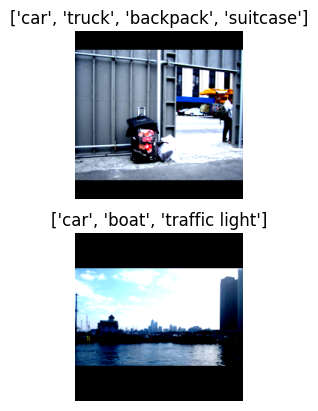

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import RegNet_Y_1_6GF_Weights

from os import listdir, path
minibatch_size = 2

img_dir_train = path.join("ms-coco","images","train-resized")
label_dir_train = path.join("ms-coco","labels","train")


n_images_train = len(listdir(img_dir_train))
class SquarePad(torch.nn.Module):
    def forward(self, img):
        _,h,w = img.size()
        pad = ((224-w)//2,(224-h)//2)
        return transforms.functional.pad(img,pad)

transform = transforms.Compose([transforms.ToTensor(),
                                SquarePad(),
                                RegNet_Y_1_6GF_Weights.DEFAULT.transforms()])

train_set = COCOTrainImageDataset(img_dir = img_dir_train,
                          annotations_dir=label_dir_train,transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=minibatch_size,
                                           shuffle=True, num_workers=0)


def imshow(ax, img, title):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0))) # NumPy expects (W, H, C)
    ax.set_title(title)
    ax.axis("off")

it = iter(train_loader) # create an iterator
images, labels = next(it) # get the next mini-batch

fig, ax = plt.subplots( minibatch_size,1) # create a 1 x 4 sub-plot

for i, (img, label) in enumerate(zip(images, labels)):

    imshow(ax[i], img, str([classes[l] for l in label.nonzero().squeeze(1)]))

<BarContainer object of 80 artists>

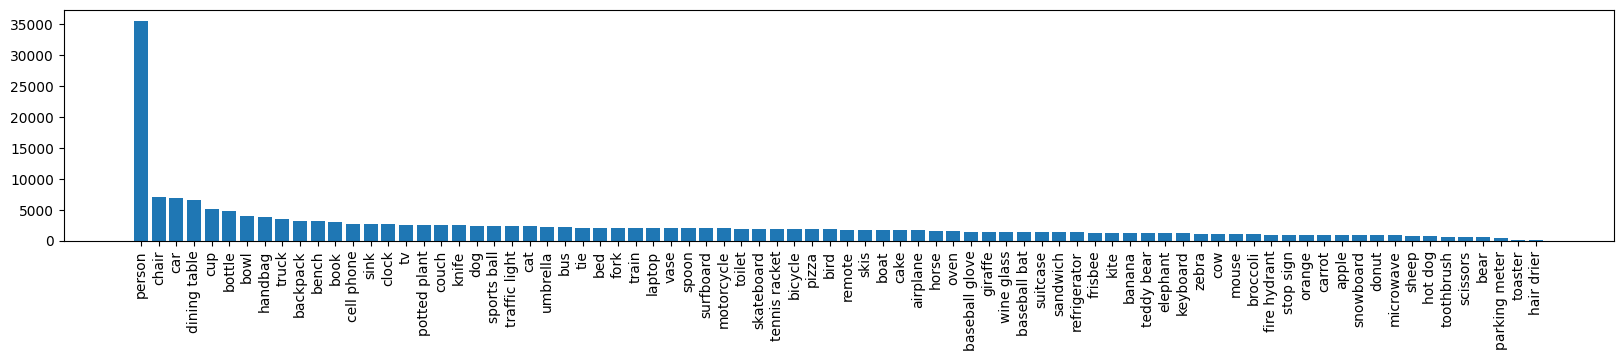

In [6]:
from collections import Counter
try :
	classes_stats = dict(np.load("label_stats.npy",allow_pickle=True).item().most_common())
except:
	list_classes = []
	list_label_files =listdir(label_dir_train)
	for labels_file_name in list_label_files:
		with open(path.join(label_dir_train,labels_file_name),'r') as f:
			list_classes.extend([int(label) for label in f.readlines()])
	
	classes_stats = dict(Counter(list_classes).most_common())
	np.save("label_stats.npy",classes_stats) 

classes_name = []
occurence = []
for k,v in classes_stats.items():
    classes_name.append(classes[k])
    occurence.append(v)
plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(classes_name,occurence)

**the image is cropped in a way that removes items present in the origina image**

## 4. training an validation of the model
### The choice of the model
We chose for this assignment the model architecture RegNet for our pretrained classification model. The architecture is described in the folowing article :

Xu, J., Pan, Y., Pan, X., Hoi, S., Yi, Z., & Xu, Z. (2021, January 3). REGNET: Self-Regulated Network for Image Classification. arXiv.org. https://arxiv.org/abs/2101.00590

Th main idea of the architecture is to cobine a ResNet with a recurrent neural network adapted for image proceesing by replacing ully-connected lyers by convolutional layers. At each step
the data processed by the ResNet layer 

In [ ]:
# import statements for python, torch and companion libraries and your own modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


import torchvision
import torchvision.transforms as transforms
from torchvision.models import RegNet_Y_1_6GF_Weights, regnet_y_1_6gf

from torchinfo import summary

from os import listdir, path
%load_ext tensorboard
# global variables defining training hyper-parameters among other things 
epochs = 5
num_workers = 0
minibatch_size = 128
learning_rate = 0.01
threshold = 0.5

# device initialization
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


# data directories initialization
img_dir_train = path.join("ms-coco","images","train-resized")
label_dir_train = path.join("ms-coco","labels","train")

img_dir_test = path.join("ms-coco","images","test-resized")
label_dir_test = path.join("ms-coco","labels","test")


# instantiation of transforms, datasets and data loaders
# TIP : use torch.utils.data.random_split to split the training set into train and validation subsets
n_images_train = len(listdir(img_dir_train))
n_images_test = len(listdir(img_dir_test))
transform = transforms.Compose([transforms.ToTensor(),
                                RegNet_Y_1_6GF_Weights.DEFAULT.transforms()])

# mini set to test code

full_train_dataset = COCOTrainImageDataset(
    img_dir=img_dir_train,
    annotations_dir=label_dir_train,
    transform=transform
)

""" train_subset = torch.utils.data.Subset(full_train_dataset, range(0, min(20000, len(full_train_dataset))))
val_subset = torch.utils.data.Subset(full_train_dataset, range(min(20000, len(full_train_dataset)), min(24000, len(full_train_dataset))))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=minibatch_size,
                            shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=minibatch_size,
                            shuffle=False, num_workers=num_workers)

print("Train samples:", len(train_subset), "Validation samples:", len(val_subset)) """ 



train_set, val_set = torch.utils.data.random_split(
    COCOTrainImageDataset(img_dir = img_dir_train,
                          annotations_dir=label_dir_train,transform=transform),
                          lengths=[n_images_train - n_images_test, n_images_test])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=minibatch_size,
                                           shuffle=True, num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=minibatch_size,
                                         shuffle=False, num_workers=num_workers)

print(n_images_train,len(train_set),len(val_set))

# class definitions


# instantiation and preparation of network model
model = regnet_y_1_6gf(weights=RegNet_Y_1_6GF_Weights.DEFAULT)

model.fc = nn.Linear(888, 80)

#print(summary(model))
model = model.to(device)

# instantiation of loss criterion
classes_weight = torch.tensor([sum(classes_stats.values())/(len(classes)*classes_stats[i]) for i in range(len(classes))]).to(device)
criterion = nn.BCEWithLogitsLoss(weight=classes_weight)
#pondérer selon les classes sous représentés

# instantiation of optimizer, registration of network parameters
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate,weight_decay=1e-4)

# definition of current best model path
best_model_path = "./best_reg.pth"
best_f1_path = "./best_f1.npy"

# initialization of model selection metric
try :
	best_val_f1 = np.load(best_f1_path).item()
except :
    best_val_f1 = 0.0
    
print(f"Best F1 : {best_val_f1}")

# creation of tensorboard SummaryWriter (optional)
writer = SummaryWriter()

# epochs loop:
for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}]")
    
    #   train
    train_loss = train_loop(train_loader, model, criterion, optimizer, device)
    train_results = {"loss": train_loss, "accuracy": 0, "f1": 0,"precision": 0, "recall": 0}
    print(f"Train   -> Loss: {train_results['loss']:.4f}")

    
    #   validate on validation set
    val_results = validation_loop(val_loader, model, criterion,
                                  num_classes=len(classes),
                                  device=device,
                                  multi_task=True,
                                  th_multi_task=threshold,
                                  one_hot=True)
    print(f"Val   -> Loss: {val_results['loss']:.4f} F1: {val_results['f1']:.4f}")
    
    #   update graphs (optional)
    update_graphs(writer,epoch,train_results,val_results)
    
    #   is new model better than current model ?
    #       save it, update current best metric
    if val_results["f1"] > best_val_f1:
        best_val_f1 = val_results["f1"]
        np.save("best_f1.npy",best_val_f1)
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with F1={best_val_f1:.4f}")


    # close tensorboard SummaryWriter if created (optional)
    writer.close()


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda
65000 60048 4952
Best F1 : 0.5003319382667542

Epoch [1/5]
Train   -> Loss: 0.1110
Val   -> Loss: 0.0920 F1: 0.4249

Epoch [2/5]
Train   -> Loss: 0.0908
Val   -> Loss: 0.0919 F1: 0.4314

Epoch [3/5]


: 

In [8]:
model = regnet_y_1_6gf(weights=RegNet_Y_1_6GF_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(888, 80)
model.load_state_dict(torch.load("best_reg.pth", map_location=device))
model = model.to(device)
val_results,class_results = validation_loop(val_loader, model, criterion,
                                  num_classes=len(classes),
                                  device=device,
                                  multi_task=True,
                                  th_multi_task=threshold,
                                  one_hot=True,
                                  class_metrics=True)


In [9]:
print(f"Val   -> Loss: {val_results['loss']:.4f} F1: {val_results['f1']:.4f}")
spaces = 15
combined = dict(zip(classes,[f1['f1'] for f1 in class_results]))
sorted_classes = dict(sorted(combined.items(), key=lambda item: item[1]))
print(f"{(spaces+3)*" "}F1")
for label,f1 in sorted_classes.items():
    print(f"{label:} : {(spaces-len(label))*" "}{f1:.4f}")


Val   -> Loss: 0.0855 F1: 0.5003
                  F1
toaster :         0.0000
knife :           0.0404
hair drier :      0.2000
backpack :        0.2078
refrigerator :    0.2128
bottle :          0.2845
cup :             0.3013
handbag :         0.3094
potted plant :    0.3322
scissors :        0.3333
book :            0.3377
cell phone :      0.3504
car :             0.3554
spoon :           0.3612
bench :           0.3824
microwave :       0.3864
wine glass :      0.3879
carrot :          0.4098
hot dog :         0.4127
cake :            0.4253
suitcase :        0.4512
chair :           0.4525
remote :          0.4571
couch :           0.4615
fork :            0.4676
vase :            0.4897
parking meter :   0.5000
donut :           0.5000
toothbrush :      0.5000
bowl :            0.5121
bicycle :         0.5161
fire hydrant :    0.5357
sandwich :        0.5385
orange :          0.5385
truck :           0.5394
snowboard :       0.5490
traffic light :   0.5517
stop sign :       0.5

## 5. The skeleton of the test submission program

This, much simpler, program should have the following sections and control flow:

In [10]:
# import statements for python, torch and companion libraries and your own modules
# TIP: use the python standard json module to write python dictionaries as JSON files
import json



# global variables defining inference hyper-parameters among other things 
# DON'T forget the multi-task classification probability threshold

# data, trained model and output directories/filenames initialization

output_path = "./submission.json"


# device initialization

# instantiation of transforms, dataset and data loader
test_set = COCOTestImageDataset(img_dir = img_dir_test, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=minibatch_size,
                            shuffle=False, num_workers=num_workers)

# load network model from saved file
model = regnet_y_1_6gf(weights=RegNet_Y_1_6GF_Weights.DEFAULT)

model.fc = nn.Linear(888, 80)
model.load_state_dict(torch.load("best_reg.pth", map_location=device))
model = model.to(device)
#print(summary(model))

# initialize output dictionary
output_dict = {}

# prediction loop over test_loader
model.eval()
with torch.no_grad():
    for data in test_loader:
        #get mini-batch
        images, ids = data[0].to(device), data[1]
        #compute network output
        outputs = model(images)
        #threshold network output

        predictions = torch.where(outputs > threshold, 1.0, 0.0).cpu()

        #update dictionary entries write corresponding class indices
        for id, pred in zip(ids,predictions):
            output_dict[id] = pred.nonzero().squeeze(1).tolist()
        

# write JSON file
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(output_dict, f, ensure_ascii=False, indent=4)
    